# Imports
This section imports all the needed libraries for the data analysis.

**Numpy**: A library written in C with a Python wrapper to give much faster computation. Allows for easy manipulation of arrays and lists with added functionality, also allows for the use of a Kalman Filter.

**Pandas**: Another library that is written in C using a Python wrapper. An extremely important library for data analysis, used for working with tabular data. Includes intuitive and additional functions that interface with **Numpy**

**Matplotlib**: A library used to visualise data.

**Seaborn**: An extension of Matplotlib that uses Matplotlib's backend. Again, used for visualising data and graphing.

**Scipy**: A library useful for process signalling and statistical analysis. Can be used to interpret data from electronic sensors.

**Sklearn**: A Machine learning library for Python that includes multiple useful loss functions such as Mean absolute error (MAE) and Mean squared error (MSE). Can be used to split data sets for testing and validating and allows for easy cross validation in machine learning algorithms. Includes the Random Forest Regression model used.

In [1]:
# Linear Algebra
import numpy as np
from filterpy.kalman import KalmanFilter

# Data Processing
import pandas as pd
from filterpy.common import Q_discrete_white_noise

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Stats
from scipy import stats

# Algorithms
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error

# Regressors
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import os

# Set random seed to be constant for reproducable results
np.random.seed(0)

sns.set()  # Stylises graphs

# Importing Data
This section imports the dataset that was converted from .mat format to .csv to allow it to be used with Python. The data had to be reformatted before this point so that is easily usable in the models.

The data is visualised in a table and checked for any null values which could cause errors in the results. The data type for each column is also checked to make sure it is consistent. The integer value for Chamber Temp is usable as Python is able to work with integer and float values together by automatically converting between the two.

In [2]:
df = pd.read_csv('./csv-data/03-18-17_02.17 25degC_Cycle_1_Pan18650PF.csv')

In [3]:
df.head()

,Voltage,Current,Ah,Wh,Power,Battery Temp,Time,Chamber Temp
0,4.14585,-1.81290,-0.00000,-0.00000,-7.516011,21.781981,0.000000,23
1,4.10532,-1.83249,-0.00005,-0.00020,-7.522958,21.781981,0.095996,23
2,4.08666,-1.85046,-0.00010,-0.00042,-7.562201,21.781981,0.202001,23
3,4.08087,-1.85781,-0.00015,-0.00062,-7.581481,21.781981,0.297997,23
4,4.07765,-1.86353,-0.00021,-0.00084,-7.598823,21.781981,0.403005,23


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109641 entries, 0 to 109640
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Voltage       109641 non-null  float64
 1   Current       109641 non-null  float64
 2   Ah            109641 non-null  float64
 3   Wh            109641 non-null  float64
 4   Power         109641 non-null  float64
 5   Battery Temp  109641 non-null  float64
 6   Time          109641 non-null  float64
 7   Chamber Temp  109641 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 6.7 MB


# Missing Values
The dataset is checked once again to ensure that there are no null values (missing data points) across the entire dataset.

In [88]:
df.isnull().sum() * 100 / df.shape[0]

Voltage         0.0
Current         0.0
Ah              0.0
Wh              0.0
Power           0.0
Battery Temp    0.0
Time            0.0
Chamber Temp    0.0
dtype: float64

# Duplicates
This function checks for any duplicates in the dataset and displays the total amount of duplicates. Duplicates in the dataset may indicate data-logging errors and so should be removed from the dataset to ensure consistent and accurate results. As there are only 3 duplicates in a large dataset they will have minimal impact on the final result of the analysis however they have still been removed from the dataset.

In [89]:
print(f'Duplicates: {df.duplicated().sum()}')

Duplicates: 3


The code below removes the duplicated data entries from the dataset.

In [3]:
df = df.drop_duplicates()

# Capacity
The typical capcity of this battery is **2784mAh**. This function converts the **Ah** measurement into a relative capacity by determining the capacity lost from the battery and dividing this by the known maximum capacity of the battery.

In [6]:
df['Capacity'] = 1 - (-df['Ah'] / 2.784)

In [95]:
df.head()

,Voltage,Current,Ah,Wh,Power,Battery Temp,Time,Chamber Temp,Capacity
0,4.14585,-1.81290,-0.00000,-0.00000,-7.516011,21.781981,0.000000,23,1.000000
1,4.10532,-1.83249,-0.00005,-0.00020,-7.522958,21.781981,0.095996,23,0.999982
2,4.08666,-1.85046,-0.00010,-0.00042,-7.562201,21.781981,0.202001,23,0.999964
3,4.08087,-1.85781,-0.00015,-0.00062,-7.581481,21.781981,0.297997,23,0.999946
4,4.07765,-1.86353,-0.00021,-0.00084,-7.598823,21.781981,0.403005,23,0.999925


# Visualisations
This section visualises the data to show any obvious trends between parameters. This allows easier understanding of the data and can be useful when tuning the statistical models to determine which variables are most important.

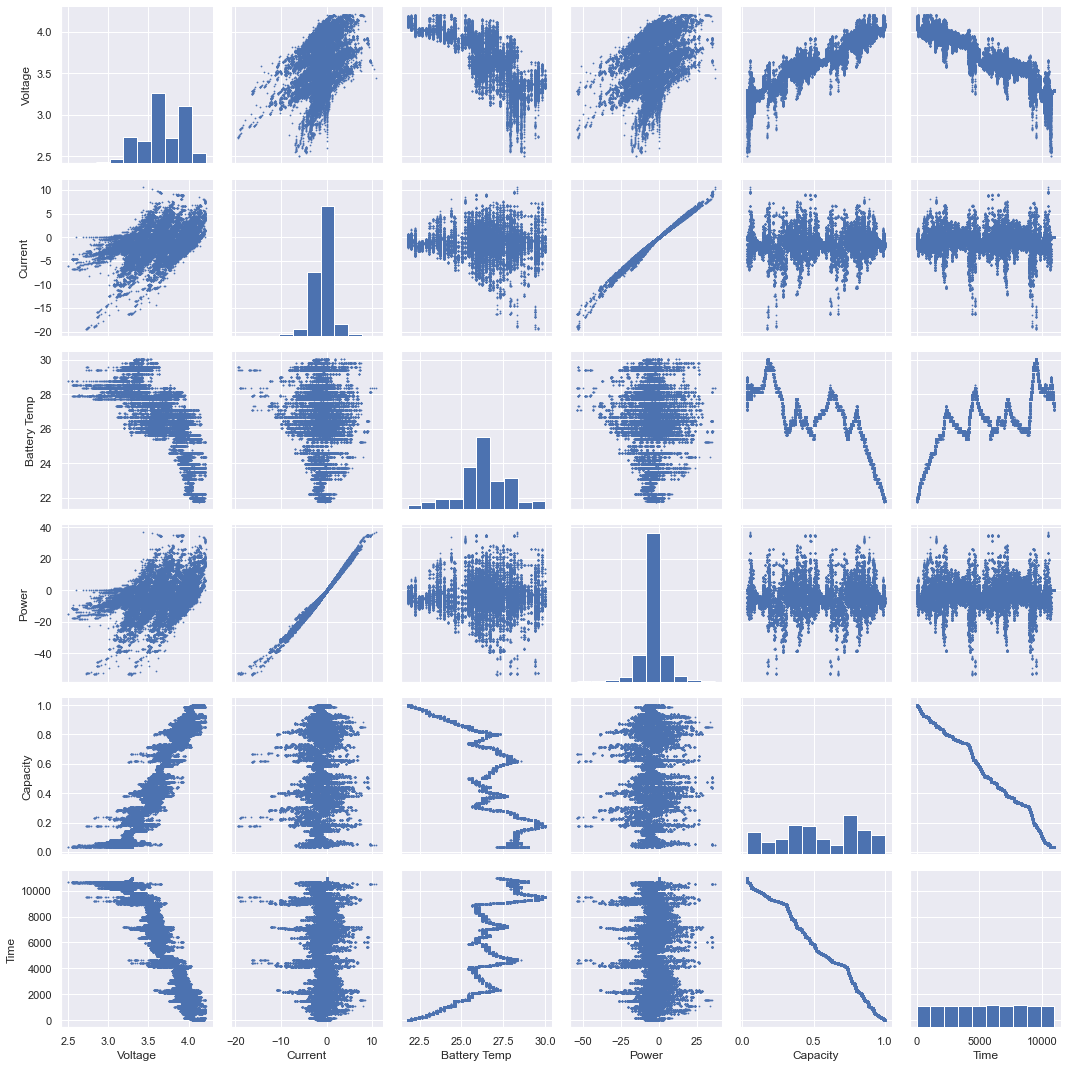

In [96]:
sns.pairplot(
    df[['Voltage', 'Current', 'Battery Temp', 'Power', 'Capacity', 'Time']],
    diag_kind='hist', palette='bright',
    plot_kws={'facecolor': 'b', 'edgecolor': 'b', 's': 1}
)

plt.tight_layout()

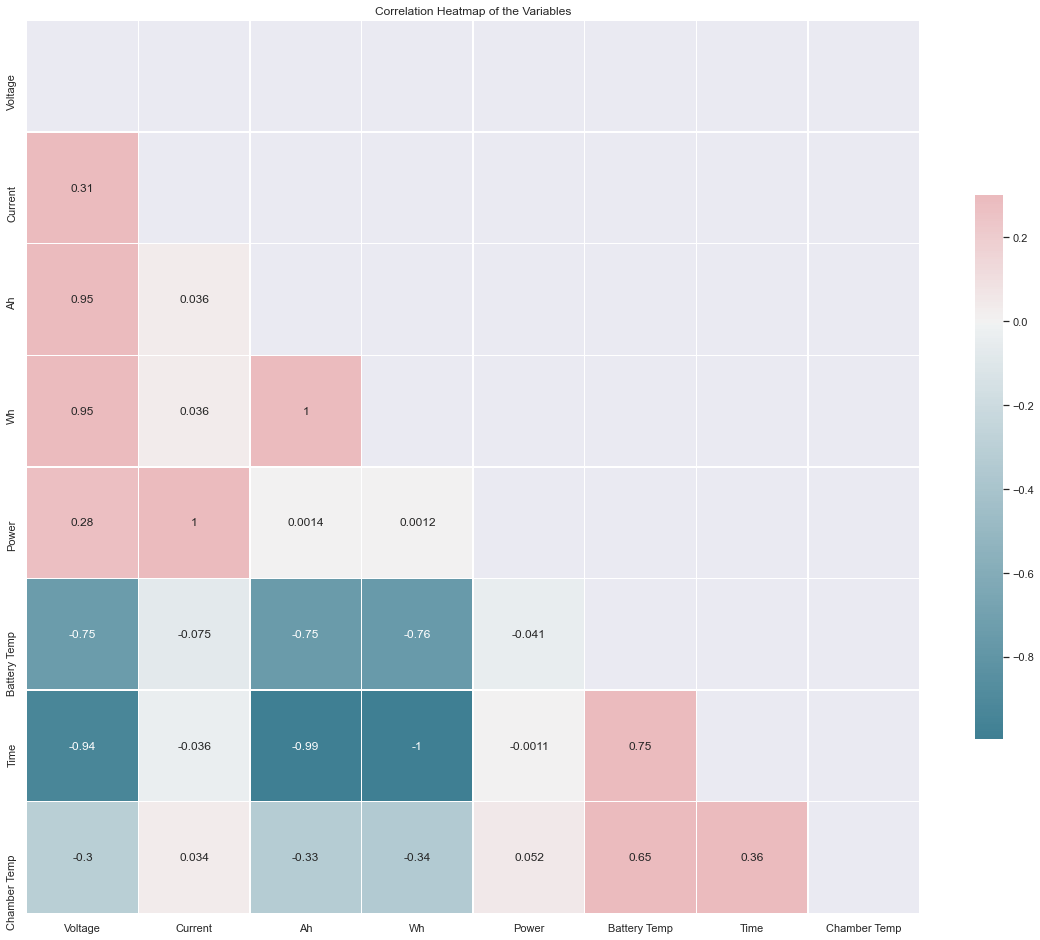

In [4]:
# Computer correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colourmap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr, mask=mask, cmap=cmap, vmax=.3, center=0,
    square=True, linewidths=.5, cbar_kws={"shrink": .5},
    annot=True
)

ax.set_title('Correlation Heatmap of the Variables')

plt.show()

## Time Period of Data Collection
This section of the code converts the time steps in the dataset into a total run time for the data set.

In [97]:
print(f"Period of data collection: {round(max(df['Time']) / (60 ** 2), 2)} hrs")

Period of data collection: 3.05 hrs


# Machine Learning
This part of the code is where the machine learning algorithms are set up.
Four different machine learning methods have been used in this program, a **Kalman filter**, **Random forest regression model**, **Support vector regression model**, and a **Recurrent Neural Network model**.

In [7]:
X = df.copy()
y = X['Capacity']

X = X.drop(columns=['Time', 'Wh', 'Ah', 'Capacity'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.01, random_state=0)

## Kalman Filter
The Kalman filter is set up as a class with several methods. This allows the parameters to be easily tuned once the model has been run, allowing for improved results. The Kalman Filter is a filtering method used to smooth out data that comes from a noisy source (such as the electronic readings for voltage in this dataset). This allows for a good approximation of the actual values despite the fluctuation in data.

In [8]:
class BatteryCapacityKalmanFilter():
    def __init__(self, X, y_measured, P, R, Q, dt):
        self.X = X
        self.y_measured = y_measured
        self.P = P
        self.R = R
        self.Q = Q
        self.dt = dt
    
    @property
    def dim_x(self):
        return self.X.shape[1]
        
    def capacity_filter(self):
        kf = KalmanFilter(dim_x=self.dim_x, dim_z=1)

        # Sets up a numpy array with Voltage, Current, Power, Bat Temp, and Chamber Temp
        kf.x = np.array(self.X.loc[0])

        # State transition matrix
        kf.F = np.array(
            [[1, self.dt],
            [0,  1]]
        )
        # Measurement function
        kf.H = np.array([[1, 0]])    
        # Measurement uncertainty
        kf.R *= self.R

        if np.isscalar(self.P):
            # Covariance matrix 
            kf.P *= self.P
        else:
            kf.P[:] = self.P
        if np.isscalar(self.Q):
            kf.Q = Q_discrete_white_noise(dim=self.dim_x, dt=self.dt, var=self.Q)
        else:
            kf.Q[:] = self.Q
        return kf
    
    def run(self):
        # Creates the Kalman filter
        kf = self.capacity_filter()  

        # Run the kalman filter and store the results in an array
        x, cov = [], []

        for y in self.y_measured:
            kf.predict()
            kf.update(y)

            x.append(kf.x[0])
            cov.append(kf.P)

        x, cov = np.array(x), np.array(cov)
        return x, cov

In [9]:
P = np.diag([1, 20])
batt_kf = BatteryCapacityKalmanFilter(
    X=X[['Current', 'Power']],
    y_measured=X['Voltage'],
    P=P, R=100, Q=0.01, dt=0.001
)
x, cov = batt_kf.run()

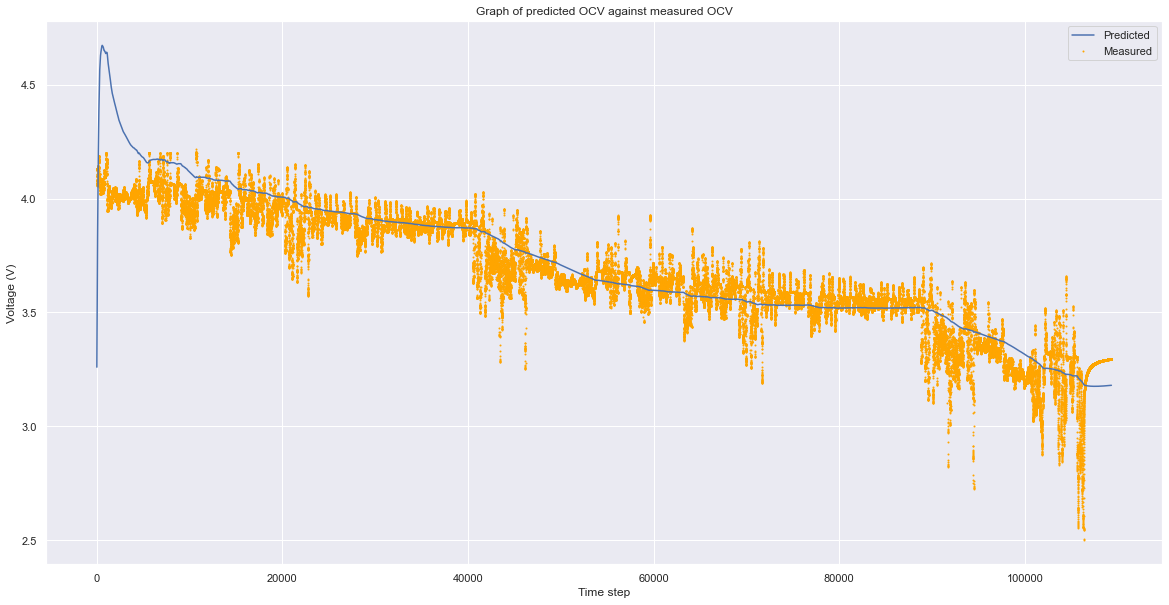

In [10]:
# Visualising the data, with measured voltage values shown in orange and the Kalman filter prediction shown in blue.
plt.figure(figsize=(20, 10))

plt.plot(x[300:], label='Predicted')
plt.scatter(
    range(len(X[300:]['Voltage'])), X[300:]['Voltage'],
    label='Measured', c='orange', s=1
)
plt.title('Graph of predicted OCV against measured OCV')
plt.xlabel('Time step')
plt.ylabel('Voltage (V)')

# plt.xticks(np.linspace(min(y), max(y)), )
plt.legend()

plt.show()

## Random Forest
This section sets up a Random forest regression model that can be used to estimate the **Ah** measurement from the other known parameters. These estimations can be used in conjunction with measurements from a coulomb counter to give much more accurate results allowing for better estimation of the State of Charge (SoC) of the battery.

The model uses 5 cross validations in an 80/20 split between training/validation. This ensures that the model is not over estimating it's ability to predict the **Ah** value thus ensuring there isn't false confidence in inaccurate results.

The mean of all 5 cross validations is then calculated and taken to be the MAE of the model.

The model is then tuned by varying the number of estimators in the Random forest model. The data is graphed to show the MAE across the different parameter numbers and from this data the optimal number of estimators can be determined and then used in the final model to ensure the best accuracy possible.

In [102]:
model_scores = -cross_val_score(
   estimator=RandomForestRegressor(),
   X=X, y=y,
   scoring='neg_mean_absolute_error', cv=5
 )

print(f'Model Scores: {model_scores}')

Model Scores: [0.16008808 0.0542119  0.09649997 0.06046793 0.33826397]


In [103]:
print(f'SoC MAE: {round(model_scores.mean() * 100, 2)}%')

SoC MAE: 14.19%


In [104]:
scores = []
n_estimators = range(2, 103, 10)

for n_estimator in n_estimators:
    rf = RandomForestRegressor(n_estimators=n_estimator, random_state=0)
    rf.fit(X_train, y_train)
    
    score = mean_absolute_error(rf.predict(X_valid), y_valid)
    scores.append(score)

In [105]:
print(f'Minimum MAE: {min(scores) * 100}%')
print(f'Optimal Number of Estimators: {(10*np.argmin(scores)) + 2}')

Minimum MAE: 1.0822612665241502%
Optimal Number of Estimators: 52


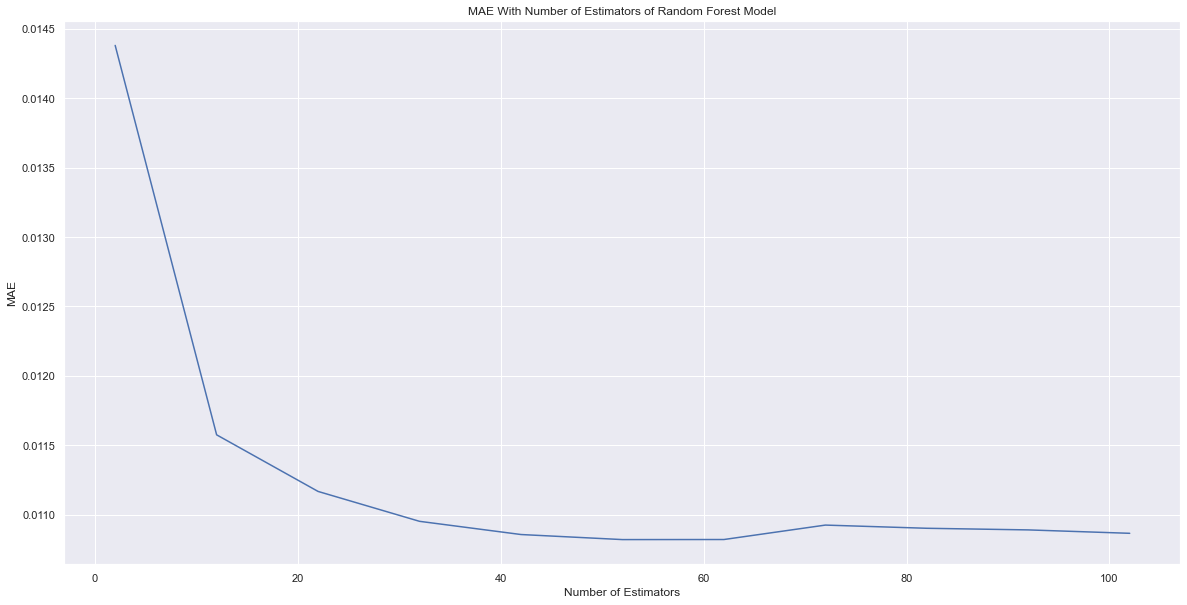

In [106]:
plt.figure(figsize=(20, 10))

plt.plot(n_estimators[:100], scores)
plt.title('MAE With Number of Estimators of Random Forest Model')
plt.xlabel('Number of Estimators')
plt.ylabel('MAE')

plt.show()

## Support Vector Machines
This section sets up and runs a Support Vector Machine (SVM) model, more specifically a Support Vector Regression (SVR) model.

There are two parameters for this model that can be tuned to improve the accuracy of the results, the Regularisation parameter, and the 𝜀  parameter as shown below.

### Regularisation Parameter
The data for the Regularisation parameter is again graphed to show the optimal parameter number for this model. As can be seen from the graph, this model gives superior results to the previous Random forest regression model even with only one parameter tuned.

In [107]:
scores = []
reg_params = np.linspace(100, 1000, 51)

for C in reg_params:
    svm = SVR(kernel='rbf', C=C)
    svm.fit(X_train, y_train)
    
    score = mean_absolute_error(svm.predict(X_valid), y_valid)
    scores.append(score)

In [108]:
print(f'Minimum MAE: {min(scores) * 100}%')
print(f'Optimal Regulator Parameter number: {round(reg_params[np.argmin(scores)], 0)}')

Minimum MAE: 5.061514315657602%
Optimal Regulator Parameter number: 658.0


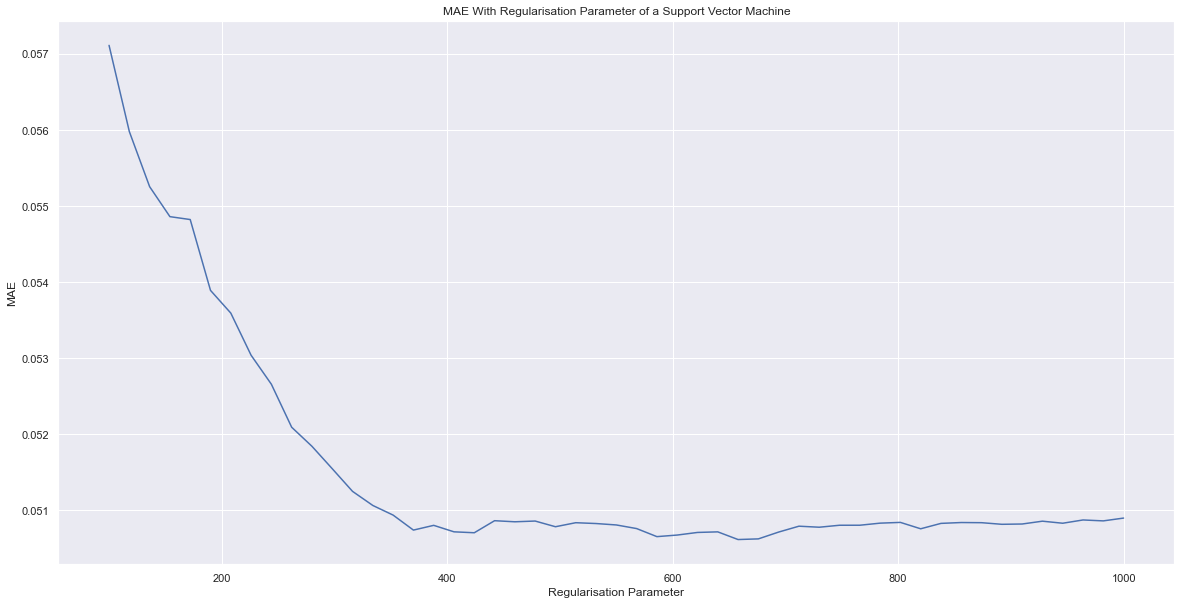

In [109]:
plt.figure(figsize=(20, 10))

plt.plot(reg_params, scores)
plt.title('MAE With Regularisation Parameter of a Support Vector Machine')
plt.xlabel('Regularisation Parameter')
plt.ylabel('MAE')

plt.show()

## $\varepsilon$ Parameter
This section graphs the varying values of 𝜀 as a parameter against MAE, again to allow the best parameters to be chosen for the model. Tuning the 𝜀 parameter, before combining with the tuned Regularisation parameter, gives a minimum MAE of 0.1044.

In [157]:
scores = []
e_values = np.linspace(1e-10, 1e-1, 51)

for e in e_values:
    svm = SVR(kernel='rbf', epsilon=e)
    svm.fit(X_train, y_train)
    
    score = mean_absolute_error(svm.predict(X_valid), y_valid)
    scores.append(score)

In [160]:
print(f'Minimum MAE: {min(scores) * 100}%')
print(f'Optimal Epsilon value: {round(e_values[np.argmin(scores)], 4)}')

Minimum MAE: 10.44287628115331%
Optimal Epsilon value: 0.01


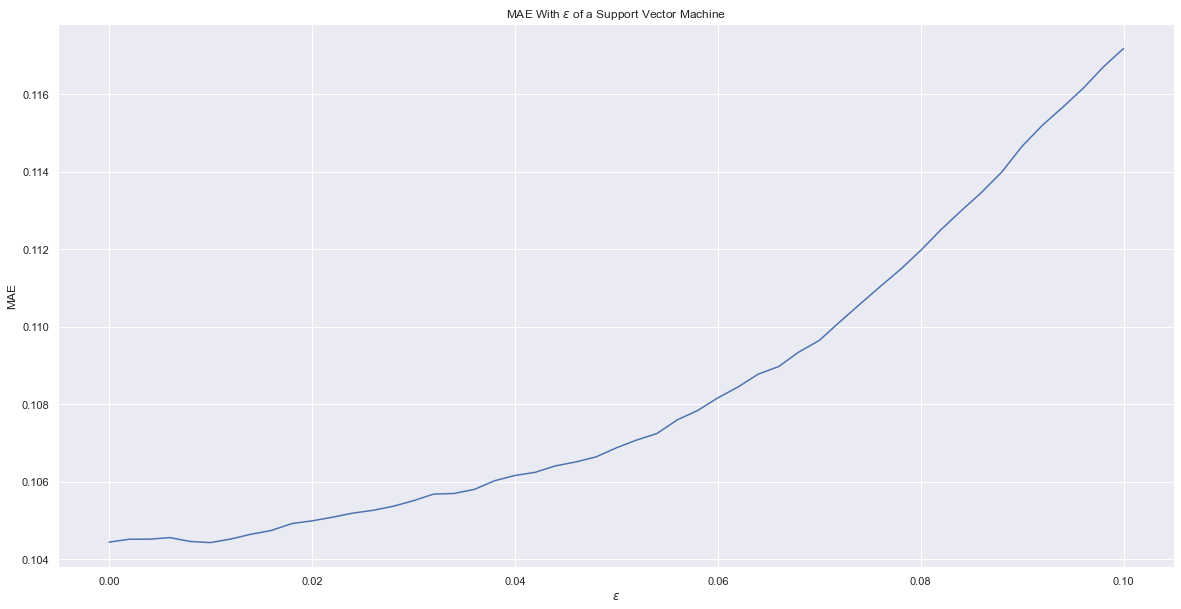

In [159]:
plt.figure(figsize=(20, 10))

plt.plot(e_values, scores)
plt.title('MAE With $\epsilon$ of a Support Vector Machine')
plt.xlabel('$\epsilon$')
plt.ylabel('MAE')

plt.show()

## Combine
The two tuned parameters are then passed into a new model that includes cross validation to ensure the model is giving the most accurate results possible. Unfortunately due to the computing power available, this was unable to be run effectively and so has been commented out to allow the remaining code to run.

In [30]:
#svm = SVR(kernel='rbf', C=658, epsilon=0.0102)

#model_scores = -cross_val_score(
#   estimator=svm,
#   X=X, y=y,
#   scoring='neg_mean_absolute_error', cv=5, n_jobs=7
#    )

#print(f'Trained SVM Score: {model_scores.mean}')

# Neural Network
This section sets up a Neural Network (NN) using a new library called Tensorflow. Tensorflow is a commonly used machine learning and deep learning library that can use the GPU in the computer to vastly improve computing times (Provided a powerful enough GPU is available).

This model is extremely resource intensive compared to the previous three models, with each iteration taking approximately 6 hours. If more time was available a Long-Short-Term-Memory (LSTM) layer would be added to the NN to improve the accuracy, this has been coded for but again, due to the computing power available has been commented out.

The NN was trialled using 1 and 2 hidden layers, with varying amounts of nodes on each iteration. The optimal solution was found to be 1 hidden layer with 4 computational nodes which is what has been shown below. This produced a MAE of 3.8%.

The amount of epochs in the NN was set to a constant 50 for each trial, however this could be massively increased and a large increase in accuracy would be expected if this was done. Increasing the amount of epochs increases the computational time per iteration and thus was set at a constant 50. In an ideal scenario, each iteration would be run for 7000 epochs and the minimum MAE across all epochs would be taken for each iteration.

The MAE and MSE are graphed below for easy comparison between each iteration.

In [31]:
import tensorflow as tf
tf.random.set_seed(13)
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [32]:
def build_model():
    model = tf.keras.Sequential()
    # Add an Embedding layer expecting input vocab of size 1000, and
    # output embedding dimension of size 64.
#     model.add(layers.Embedding(input_dim=5, output_dim=1))

     # Add a LSTM layer with 128 internal units.
#     model.add(layers.LSTM(128))

     # Add a Dense layer with 10 units.
#     model.add(layers.Dense(10))
    model = tf.keras.Sequential([
        layers.Dense(4, activation='relu', input_shape=[len(X.keys())]),
        layers.Dense(1)
    ])


    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(
        loss='mse', optimizer=optimizer, metrics=['mae', 'mse']
    )

    return model

In [33]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________


In [34]:
EPOCHS = 7000

with tf.device('/device:CPU:0'):
    history = model.fit(
        X, y,
        epochs=EPOCHS, validation_split=0.2, verbose=0,
        callbacks=[tfdocs.modeling.EpochDots()]
    )


Epoch: 0, loss:0.2240,  mae:0.2411,  mse:0.2240,  val_loss:0.0455,  val_mae:0.1879,  val_mse:0.0455,  
....................................................................................................
Epoch: 100, loss:0.0011,  mae:0.0264,  mse:0.0011,  val_loss:0.0081,  val_mae:0.0513,  val_mse:0.0081,  
....................................................................................................
Epoch: 200, loss:0.0010,  mae:0.0247,  mse:0.0010,  val_loss:0.0092,  val_mae:0.0522,  val_mse:0.0092,  
....................................................................................................
Epoch: 300, loss:0.0009,  mae:0.0240,  mse:0.0009,  val_loss:0.0080,  val_mae:0.0527,  val_mse:0.0080,  
....................................................................................................
Epoch: 400, loss:0.0009,  mae:0.0236,  mse:0.0009,  val_loss:0.0088,  val_mae:0.0510,  val_mse:0.0088,  
........................................................................

In [35]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [SOC]')

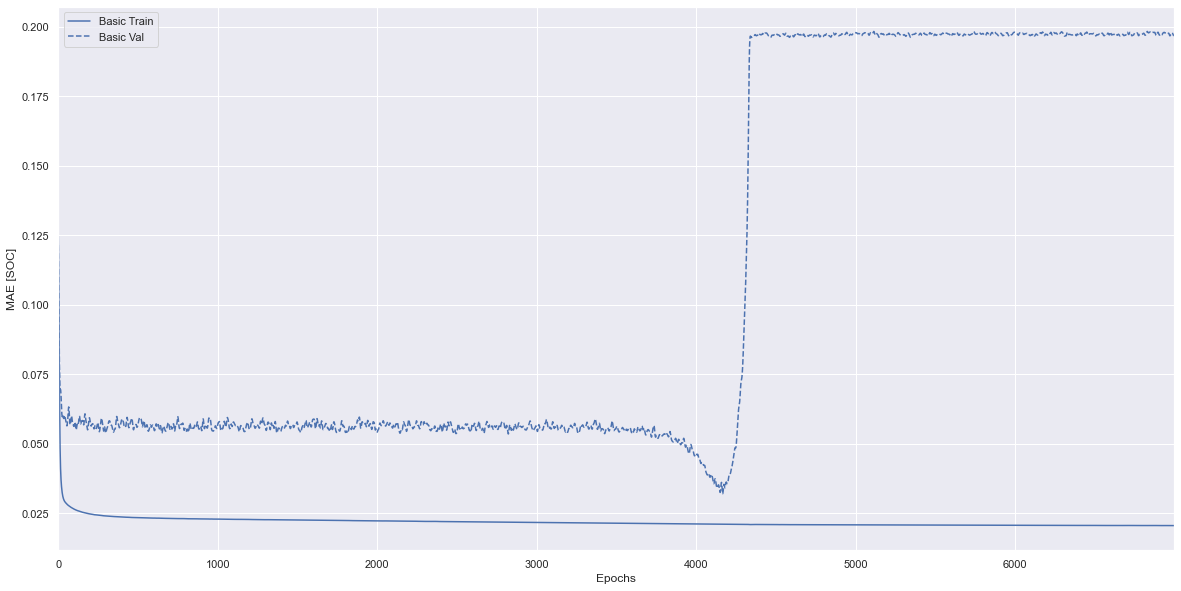

In [36]:
plt.figure(figsize=(20, 10))
plotter.plot({'Basic': history}, metric = "mae")
plt.ylabel('MAE [SOC]')

Text(0, 0.5, 'MSE [$SOC^{2}$]')

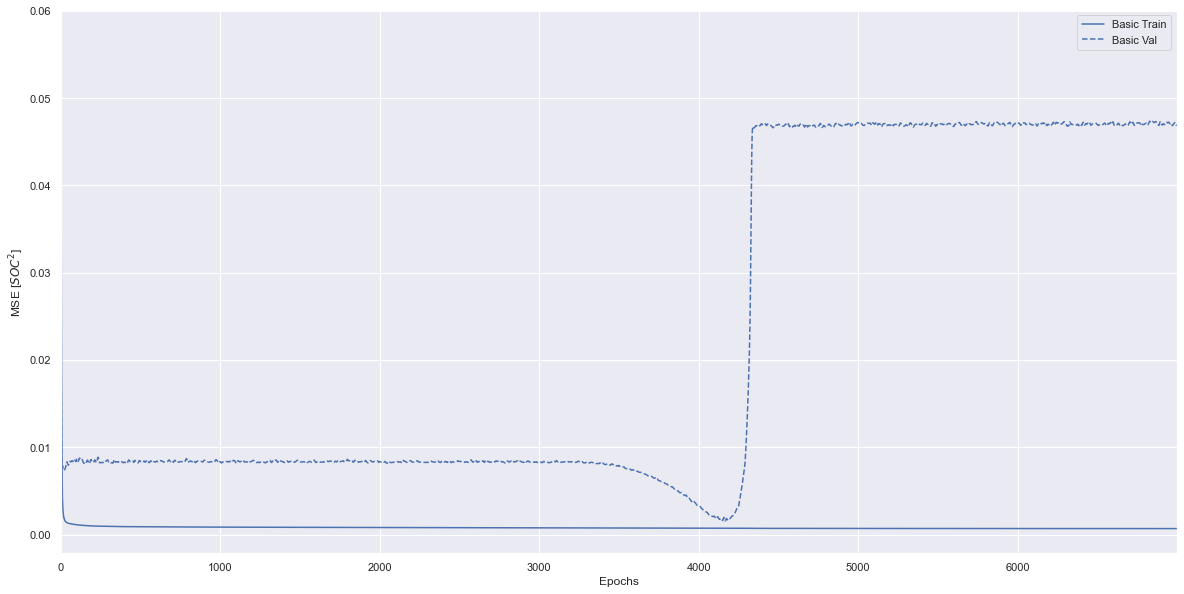

In [44]:
plt.figure(figsize=(20, 10))
plotter.plot({'Basic': history}, metric = "mse")
plt.ylabel('MSE [$SOC^{2}$]')

## Validation of Model
This section uses the remaining drive cycle data sets to test the actual error of the model when used on data that is completely new to the model.

In [59]:
dfs = [
    pd.read_csv(os.path.join(dp, f)) for
    dp, dn, filenames in os.walk('./csv-data')
    for f in filenames if (os.path.splitext(f)[1] == '.csv') 
]
        
df3 = pd.concat(dfs, axis=0, ignore_index=True)
del dfs

In [60]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1126083 entries, 0 to 1126082
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Voltage       1126083 non-null  float64
 1   Current       1126083 non-null  float64
 2   Ah            1126083 non-null  float64
 3   Wh            1126083 non-null  float64
 4   Power         1126083 non-null  float64
 5   Battery Temp  1126083 non-null  float64
 6   Time          1126083 non-null  float64
 7   Chamber Temp  1126083 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 68.7 MB


In [62]:
df3['Capacity'] = 1 - (-df3['Ah'] / 2.784)

In [63]:
X = df3.copy()
y = X['Capacity']

X = X.drop(columns=['Time', 'Wh', 'Ah', 'Capacity'])

In [64]:
mean_absolute_error(model.predict(X), y)

0.06964233280510271